## M13

### Test starfinders

In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits 
from astropy.stats import * 
from photutils.background import Background2D, MedianBackground, MMMBackground
from photutils.detection import DAOStarFinder 
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

In [2]:
#First define the image in python as a string.
imagefile = "M13_g_align.fit" 
image = fits.open(imagefile)[0].data
header = fits.open(imagefile)[0].header

In [3]:
print(image.shape)

(2042, 3054)


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_89586/1794141150.py:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), #We usually take the log of an image to see the variance of the pixels better.


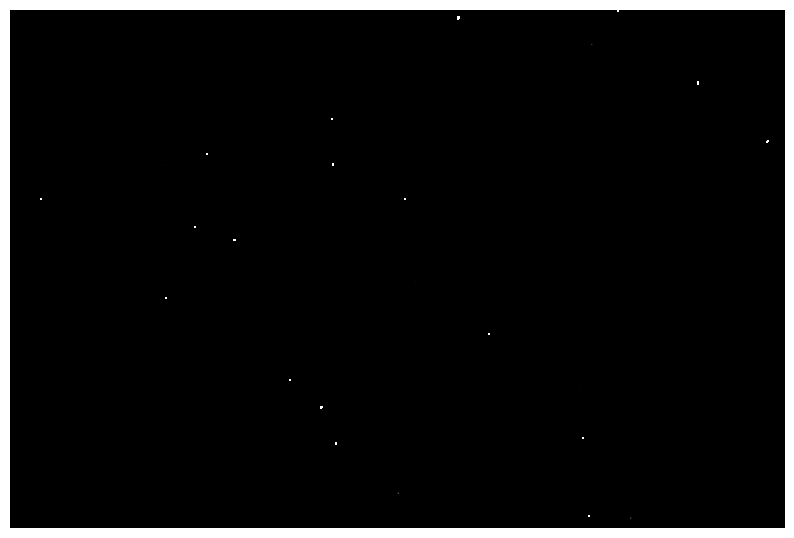

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), #We usually take the log of an image to see the variance of the pixels better.
            origin='lower', #This tells matplotlib where the [0,0] index is. For our images it is in the bottom.
            cmap = "gray", #Use whatever colormap you like, but I find gray the easiest to visualize.
            vmin = 6, vmax = 11) #This defines the data range we want to see. There are ways to automate this but I always do it manually.
plt.axis('off') #This removes the axes, which aren't really relevant for just viewing an image.
plt.show()

In [5]:
mjd = header['MJD-OBS']
print("The Modified Julian Date is", mjd)

The Modified Julian Date is 60067.9566047


In [6]:
sigma_clip = SigmaClip(sigma=3, cenfunc='mean') #doesn't change much for inf sigma
mean, median, std = sigma_clipped_stats(image, sigma=3, cenfunc='mean') 

bkg_estimator = MedianBackground() 
bkg = Background2D(image, 
                    box_size=(50, 50), 
                    filter_size=(9, 9), 
                    sigma_clip=sigma_clip, 
                    bkg_estimator=bkg_estimator) 
bkg_ = bkg.background
bkg_median = bkg.background_median
bkg_rms = bkg.background_rms_median

mmm_bkg = MMMBackground()

daofind = DAOStarFinder(fwhm=3, #smaller <1, more bright stars
                        threshold=std*4,
                        #brightest= 200
                       ) 
sources = daofind(image - bkg_median) #doesn't change if not subtract bkg
print(sources)


 id      xcentroid      ...        flux                 mag         
---- ------------------ ... ------------------ ---------------------
   1  43.79695981035774 ...  1.064501166343689  -0.06786535404682248
   2  1773.707986455734 ... 21.894123077392578   -3.3508188878331175
   3 1330.8923957974564 ... 1.0511635541915894  -0.05417573668491892
   4    2616.0557472381 ... 1.0570448637008667   -0.0602335506816252
   5  2742.806198262361 ...  2.348836898803711   -0.9271321519814696
   6 1401.2362838341917 ... 1.0249907970428467  -0.02679991515881915
   7  2790.710111744914 ... 1.0889453887939453  -0.09251525049102462
 ...                ... ...                ...                   ...
1158  3.298233128018678 ... 1.0060172080993652 -0.006513523665281533
1159  732.2703620550558 ... 3.0458528995513916   -1.2092723127858749
1160 144.90507974995387 ...  1.159446120262146   -0.1606264291868003
1161 1835.0590967044193 ...  3.653639793395996   -1.4068143217917164
1162 2394.9260339815037 ... 38.575

In [7]:
image_ = (image - bkg_median)
brightest = sorted(image_.flatten())[:18]
print(mean, median, std, sorted(image_.flatten())[:10])
print(bkg_median,bkg_rms)
print(np.where(image==brightest))
print(np.nanstd(image))

34.757893 34.711033 3.5849087 [-1577.5413, -930.76776, -529.29034, -386.76605, -365.05624, -316.51974, -315.5138, -287.77408, -252.12259, -224.38138]
34.62682342529297 3.4456897243605695
(array([], dtype=int64),)
16.197168


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_89586/1379437242.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(np.where(image==brightest))


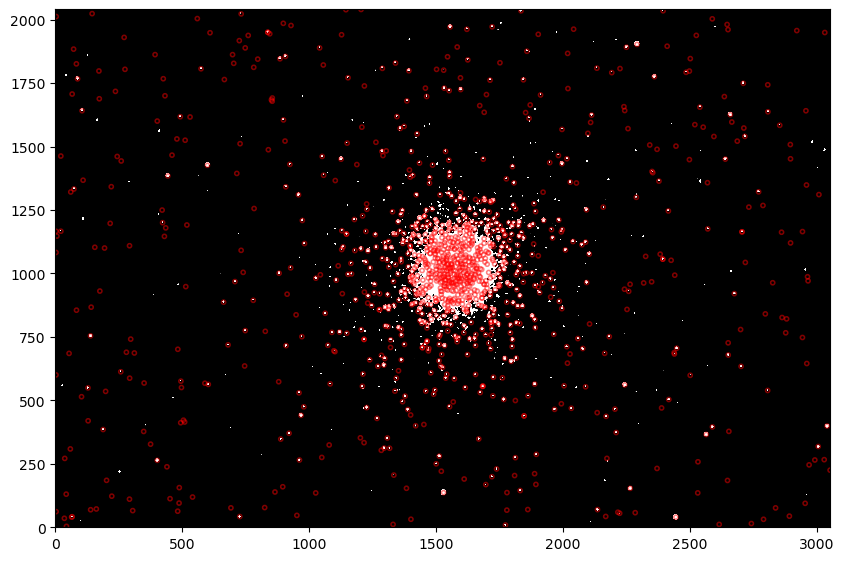

In [8]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=3) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(image - bkg_median, origin='lower', cmap = "gray", vmin=10, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5) 
plt.show()

In [9]:
print(np.median(sources['flux']),sources['flux'].std())

1.4945008754730225 25.03264608064816


In [10]:
for bright in brightest:
    positions = list(positions)
    positions.append(np.where(image==bright))
    
positions = np.array(positions)
print(positions.shape)

(1182, 2)


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_89586/942857213.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  positions = np.array(positions)


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_89586/902176125.py:6: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)


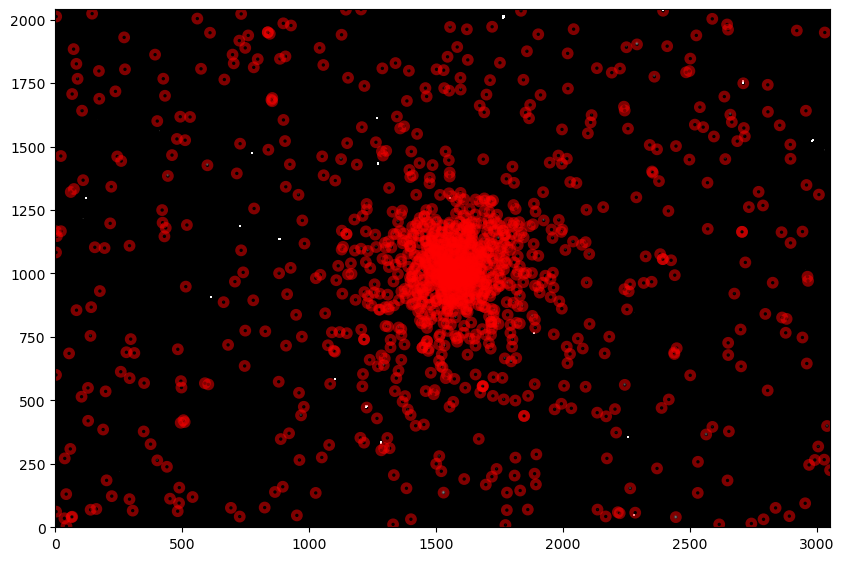

In [11]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=15) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5) 
plt.show()

In [12]:
import sep
datasw = image.byteswap(False).newbyteorder()
bkg0=sep.Background(datasw)
data_sub=datasw-bkg0
objects = sep.extract(datasw-bkg0.back(), bkg0.globalrms*3, minarea =10, segmentation_map=False)

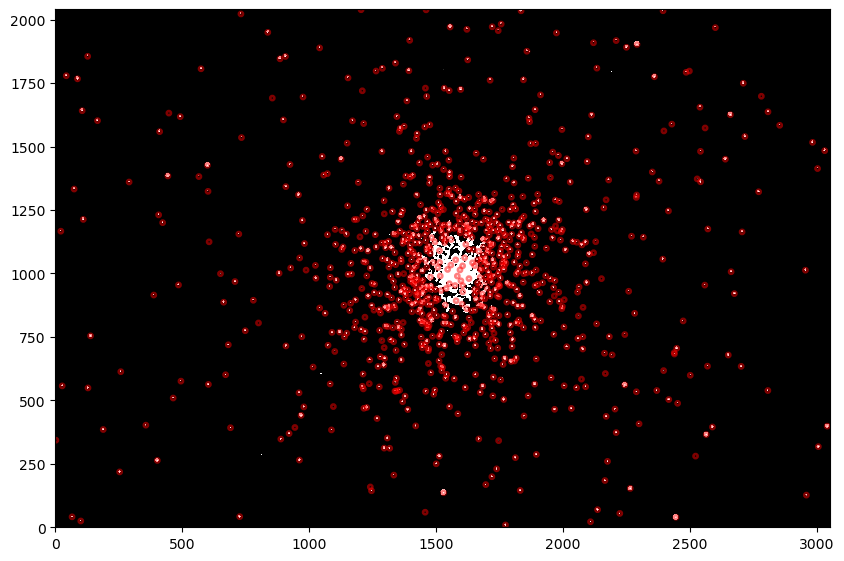

In [13]:
positions = np.transpose((objects['x'], objects['y'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=5) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(data_sub, origin='lower', cmap = "gray", vmin=10, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5) 
plt.show()

In [14]:
print(objects['b'][-10:-1],objects['b'].std(), np.median(objects['b']),
      objects['a'].mean(),objects['b'].std(), np.median(objects['a'])  )

[1.78134358 0.75457978 1.62149477 2.45948362 0.77108264 0.87938434
 0.82455385 1.61427605 1.18602836] 1.1252473729034587 1.689403772354126 2.441825503038757 1.1252473729034587 1.9435429573059082


In [15]:
table = aperture_photometry(data_sub, apertures)
print(table)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 1773.8860497803646  8.655002132728766 2191.3972661986863
  2 2108.9345720506103  21.26586844770829 380.24146961597165
  3  100.2562620510747  24.26970028784933  630.9774545490588
  4  65.88686889236374  40.59465549208446  791.7066931582224
  5  726.4954735824375 41.458628390338795 1838.5297837768076
  6  2445.408312308892  39.08337130993737  65850.52619586112
...                ...                ...                ...
903 1555.5507962832444 1970.8731404261105   6948.96542482281
904 1756.8246950569546 1982.4365660219028  902.4778099665276
905  731.3125365854435 2022.3370800722635  621.2878718092473
906  2394.728723141711 2034.9790941655847 2475.4084349748982
907  1204.777901040581 2038.9755869156668  2773.784916674254
908 1460.9782066452392 2038.5328449241524   763.314027084027
909 1835.1697889940301 2

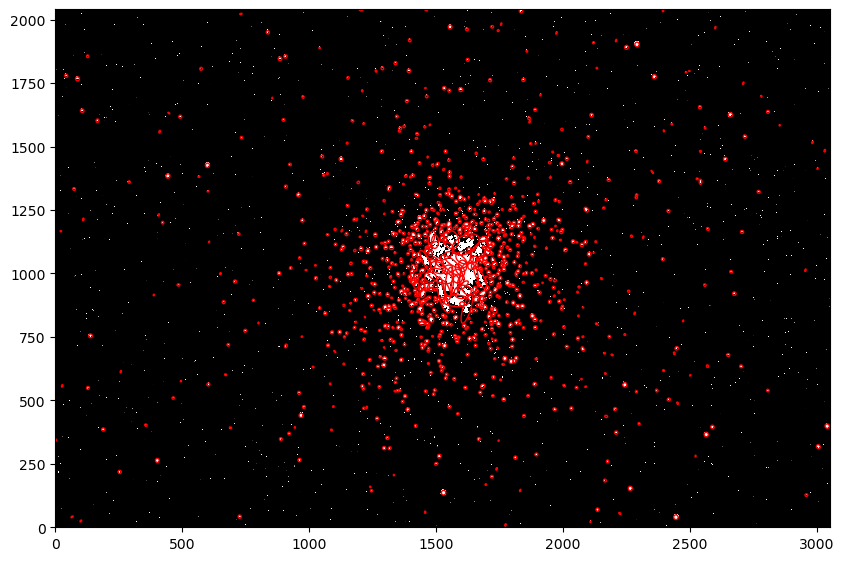

In [16]:
from matplotlib.patches import Ellipse
# plot background-subtracted image
fig, ax = plt.subplots(figsize=(10,10))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', 
vmin=10, vmax=11, origin='lower')
# plot an ellipse for each object 
for i in range(len(objects)):
  e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
  width=6*objects['a'][i],
  height=6*objects['b'][i],
  angle=objects['theta'][i] * 180. / np.pi)
  e.set_facecolor('none')
  e.set_edgecolor('red')
  ax.add_artist(e)

In [17]:
print(np.median(objects['flux']),objects['flux'].std())

1149.3243408203125 12764.971827415044


## Masking

836


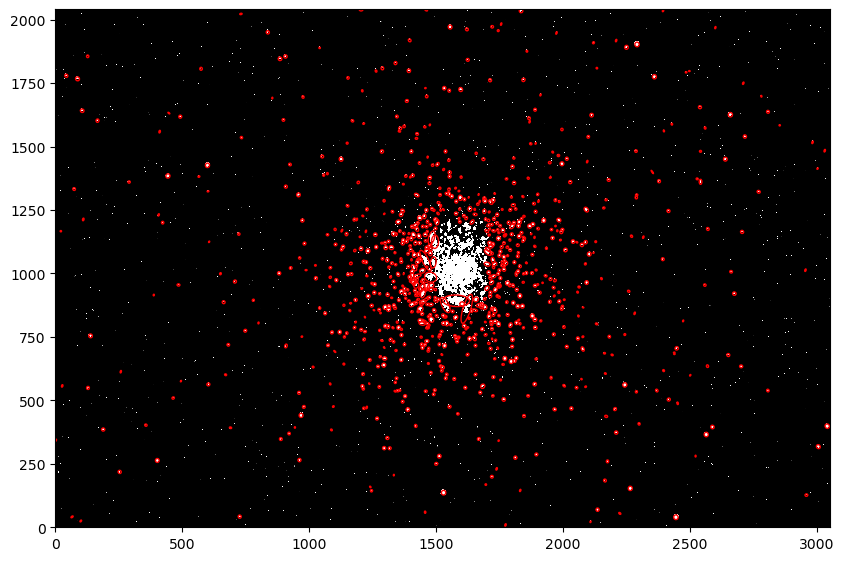

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
vmin=10, vmax=11, origin='lower')
# plot an ellipse for each object
count = 0
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
    width=6*objects['a'][i],
    height=6*objects['b'][i],
    angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    if objects['x'][i]<=1700 and objects['x'][i]>=1500 and objects['y'][i]<=1200 and objects['y'][i]>=900:
        None
    else:
        ax.add_artist(e)
        count +=1
print(count)

In [70]:
print(objects['tnpix'],'/', objects['npix'])

[  16   10   16   14   64  368   20   16   74   32   26  383   16   10
  198   14   47   44    7   67   16   55   39  131   65   66   10  118
   54   48   76  114    9   15   50   50   56   39  237   77   16   65
   18   10   91   43   32  187   23   56   37   49  176   33   63  104
   56   30   58   16   50   12   51   18   46   58  103   31   62   35
   36   42   53   54   28    6   12   40   30   25   35   36   43   31
   55   53   41   17   40   61   31   17  126   56   18    8  103  234
   29    7   15    8   53   34   56   28   55   10   17   37   45   48
   12   46   13   39   18   16   44   88   40   55   29   25   16  175
   19   55   50   54  200   82   29   21  100   76  161   26   15   16
   58   44    9   15    7   12   25   38   36   46   79   15    8   88
   63   52   57   56   48   47   36   44   38   40  176   43   28   33
   46   19   87   30   42   64    7  124   63  123  100   26   11   26
   15   16   41  100   46   46  116   63   43   15   42   47   28   57
    8 

In [19]:
def mask(objects,x_min = 1500, x_max = 1700, y_min = 900, y_max = 1200):
    '''
    x_min, x_max, y_min, y_max define the masked area
    '''
    indices = []
    objects = np.array(objects)
    for i in range(len(objects)):
        if objects['x'][i]<=x_max and objects['x'][i]>=x_min and objects['y'][i]<=y_max and objects['y'][i]>=y_min:
            indices.append(i)
        else:
            None
    objects = np.delete(objects, indices)
    return objects

In [20]:
print(np.median(mask(objects)['flux']),mask(objects)['flux'].std())

1073.1536865234375 7761.30422890171


### Photometry

In [21]:
import mplhep as hep

In [22]:
def photometry(data, data2):
    datasw = data.byteswap(False).newbyteorder()
    bkg0=sep.Background(datasw)
    data_sub=datasw-bkg0
    objects = sep.extract(datasw-bkg0.back(), bkg0.globalrms*3, minarea =10, segmentation_map=False)
    objects = mask(objects)
    positions_ = np.transpose((objects['x'], objects['y']))

    
    apertures = CircularAperture(positions_, r=5)
    phot_table = aperture_photometry(data_sub, apertures)
    aperture_sums_ = phot_table['aperture_sum']
    
    data2sw = data2.byteswap(False).newbyteorder()
    bkg02=sep.Background(data2sw)
    data_sub02=data2sw-bkg02
    phot_table2 = aperture_photometry(data_sub02, apertures)
    aperture_sums2_ = phot_table2['aperture_sum']
    
    positions = []
    aperture_sums = []
    aperture_sums2 = []
    
    for i, as2 in enumerate(aperture_sums2_):
        if as2 >0:
            positions.append(positions_[i, :])
            aperture_sums.append(aperture_sums_[i])
            aperture_sums2.append(aperture_sums2_[i])
            
    return positions, aperture_sums, aperture_sums2, data_sub, data_sub02

In [23]:
imagefile_g = "M13_g_align.fit" 
aligned_g = fits.open(imagefile_g)[0].data
header_g = fits.open(imagefile_g)[0].header

imagefile_r = "M13_r_align.fit" 
aligned_r = fits.open(imagefile_r)[0].data
header_r = fits.open(imagefile_r)[0].header

In [24]:
positions, sums_g, sums_r, data_sub, data_sub02 = photometry(aligned_g, aligned_r)
print(len(positions), len(sums_g), len(sums_r))
print(positions)

823 823 823
[array([1773.88604978,    8.65500213]), array([2108.93457205,   21.26586845]), array([726.49547358,  41.45862839]), array([2445.40831231,   39.08337131]), array([2224.32551598,   54.16974112]), array([1457.21647065,   58.85036009]), array([2136.70799866,   68.87312452]), array([2959.61569212,  126.28620308]), array([1245.83808091,  143.28635236]), array([1529.93369439,  135.83694552]), array([1831.86386071,  144.60849921]), array([1241.14991602,  158.46914472]), array([2265.55591519,  152.70140025]), array([2165.78842389,  183.72880679]), array([1720.25259025,  198.72425597]), array([1333.86458344,  205.07869849]), array([253.46300268, 217.66367529]), array([1738.91813111,  229.6388552 ]), array([1500.8871043 ,  249.54470593]), array([2175.87770166,  259.26325992]), array([401.80215647, 262.84735451]), array([961.95393976, 264.30940164]), array([1812.89494218,  273.86897001]), array([2522.90008751,  279.99906491]), array([1512.96456449,  279.64698964]), array([1895.53120269

In [25]:
apertures = CircularAperture(positions, r=5)
table = aperture_photometry(data_sub, apertures)
print(table)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 1773.8860497803646  8.655002132728766 2191.3972661986863
  2 2108.9345720506103  21.26586844770829 380.24146961597165
  3  726.4954735824375 41.458628390338795 1838.5297837768076
  4  2445.408312308892  39.08337130993737  65850.52619586112
  5 2224.3255159799505  54.16974111533244  627.4551725206477
  6 1457.2164706525073  58.85036009021138  572.7126674895059
...                ...                ...                ...
817 1555.5507962832444 1970.8731404261105   6948.96542482281
818 1756.8246950569546 1982.4365660219028  902.4778099665276
819  731.3125365854435 2022.3370800722635  621.2878718092473
820  2394.728723141711 2034.9790941655847 2475.4084349748982
821  1204.777901040581 2038.9755869156668  2773.784916674254
822 1460.9782066452392 2038.5328449241524   763.314027084027
823 1835.1697889940301 2

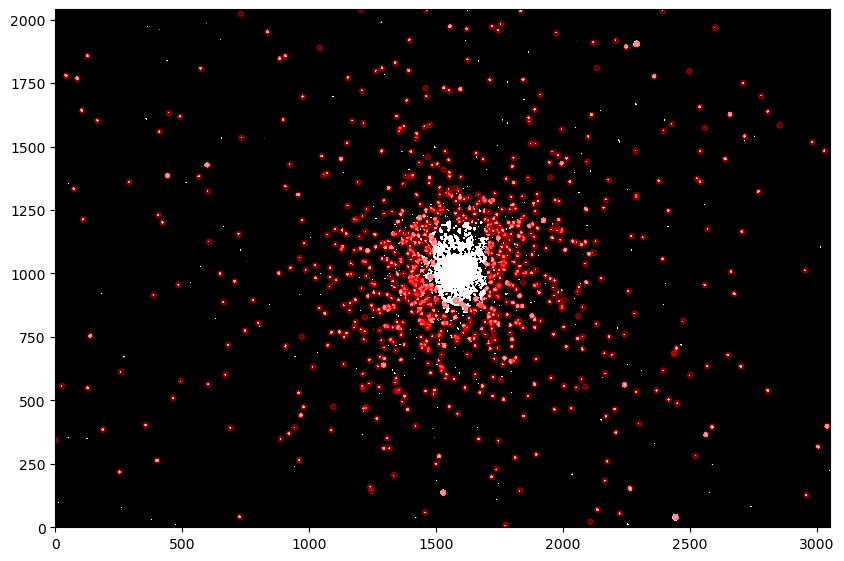

In [26]:
data2sw = aligned_r.byteswap(False).newbyteorder()
bkg02=sep.Background(data2sw)
apertures = CircularAperture(positions, r=5) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(data2sw-bkg02, origin='lower', cmap = "gray", vmin=10, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5) 
plt.show()

In [27]:
color = []
Gmag = []
Rmag = []
for i in range(len(positions)):
        mag_g = -2.5*np.log10(sums_g[i])
        mag_r = -2.5*np.log10(sums_r[i])
        color.append(mag_g-mag_r)
        Gmag.append(mag_g)
        Rmag.append(mag_r)

In [38]:
print(f'Avg mag of stars in cluster g band: {np.mean(Gmag)}, r band: {np.mean(Rmag)}')
print(f'Avg mag of brightest 25 g band: {np.mean(sorted(Gmag)[:25])},r band: {np.mean(sorted(Rmag)[:25])}')

Avg mag of stars in cluster g band: -7.910315163929365, r band: -8.356724764695747
Avg mag of brightest 25 g band: -10.819714777488592,r band: -11.759102335877358


In [ ]:
#print(np.array(sums_r)>0)

Text(0.5, 1.0, 'M13')

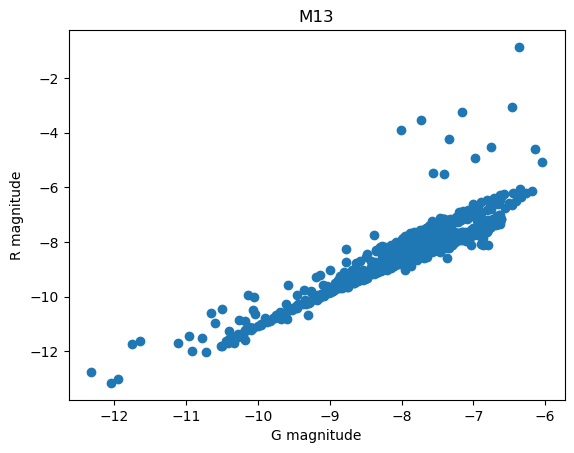

In [39]:
plt.scatter(Gmag,Rmag)
plt.xlabel('G magnitude')
plt.ylabel('R magnitude')
plt.title('M13')

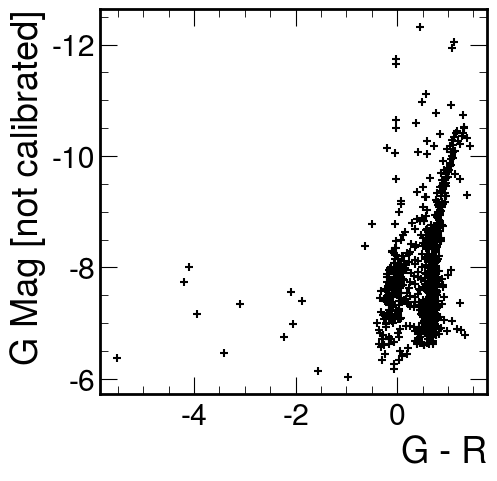

In [40]:
plt.figure(figsize=(5,5))
plt.style.use(hep.style.ROOT)
plt.scatter(np.array(color), Gmag, marker='+', c = 'k')
plt.xlabel('G - R')
plt.ylabel('G Mag [not calibrated]')
#plt.xlim(-2, 3)
plt.gca().invert_yaxis()

In [41]:
from scipy.stats import sigmaclip

In [43]:
Gmag_clipped= []
color_clipped = []
color = np.array(color)
for i, c in enumerate(color):
    if c > color.mean() - 3*color.std() and c < color.mean() + 3*color.std():
        color_clipped.append(c)
        Gmag_clipped.append(Gmag[i])
    else:
        None
print(color.shape, len(color_clipped), len(Gmag_clipped))

(823,) 812 812


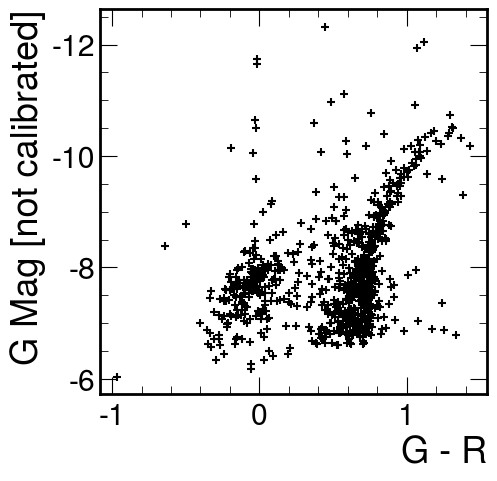

In [44]:
plt.figure(figsize=(5,5))
plt.style.use(hep.style.ROOT)
plt.scatter(np.array(color_clipped), Gmag_clipped, marker='+', c = 'k')
plt.xlabel('G - R')
plt.ylabel('G Mag [not calibrated]')
#plt.xlim(-2, 3)
plt.gca().invert_yaxis()

### Reference star calibration

In [45]:
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.wcs.utils import skycoord_to_pixel

wcs = WCS(header_g)  
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 250.423087517  36.4676224178  
CRPIX : 1527.5  1021.5  
CD1_1 CD1_2  : -1.10403902678e-06  0.000158527361147  
CD2_1 CD2_2  : -0.000158527361147  -1.10403902678e-06  
NAXIS : 3054  2042


Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [46]:
RA = ['16h40m54.9s', 
'16h40m59.7s',
'16h41m23.5s',
'16h42m01.1s',
'16h42m22.9s']

DEC = ['+36d19m22s',
'+36d28m04s',
'+36d30m17s',
'+36d36m51s',
'+36d20m43s']

ra = Angle(RA)
dec = Angle(DEC)
ref_coord = SkyCoord(ra, dec, frame='icrs')
print(f'RA = {ra}; DEC = {dec}')
print(ref_coord)

RA = [16.68191667 16.68325    16.68986111 16.70030556 16.70636111] hourangle; DEC = [36.32277778 36.46777778 36.50472222 36.61416667 36.34527778] deg
<SkyCoord (ICRS): (ra, dec) in deg
    [(250.22875   , 36.32277778), (250.24875   , 36.46777778),
     (250.34791667, 36.50472222), (250.50458333, 36.61416667),
     (250.59541667, 36.34527778)]>


In [47]:
ref_xy = skycoord_to_pixel(ref_coord,wcs)

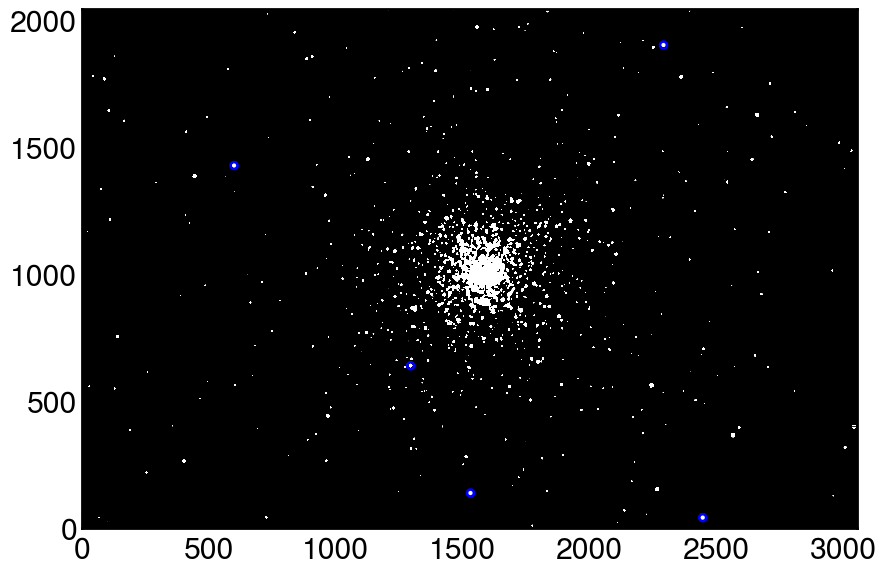

In [48]:
ref_positions = np.transpose((ref_xy[0], ref_xy[1])) #Positions are transposed by default.
apertures = CircularAperture(ref_positions, r=5) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(data_sub, origin='lower', cmap = "gray", vmin=10, vmax = 11)
v = apertures.plot(color='blue', lw=5, alpha=1) 
plt.show()

In [49]:
positions, sums_g, sums_r, data_sub, data_sub02 = photometry(aligned_g, aligned_r)
    
ref_apertures = CircularAperture(ref_positions, r=5)

phot_table = aperture_photometry(data_sub, ref_apertures)
ref_g_uncali = -2.5*np.log10(phot_table['aperture_sum'])
    
phot_table2 = aperture_photometry(data_sub02, ref_apertures)
ref_r_uncali = -2.5*np.log10(phot_table2['aperture_sum'])

In [62]:
print(ref_g_uncali)

print(ref_r_uncali)

print(phot_table2)

    aperture_sum   
-------------------
-12.036324394752292
-12.295883943220877
-10.307639114367838
 -11.09451628593525
-11.916939640022182
    aperture_sum   
-------------------
-13.124715223187504
 -12.69054432733004
-11.722994235866185
-11.610886673095042
-13.068007936335658
 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 2446.0324046092155  39.20608443821118  177781.3047830106
  2  1530.879274583145  136.1348431058458  119183.9379790535
  3  1294.989157838504  637.7361422697862 48887.484846855856
  4  599.0843647401192 1426.6796053788469  44091.47922724048
  5  2291.343043897116 1901.4154445052343 168734.22244369634


-22.388260675659687
slope:  1
y intercept:  22.388260675659687


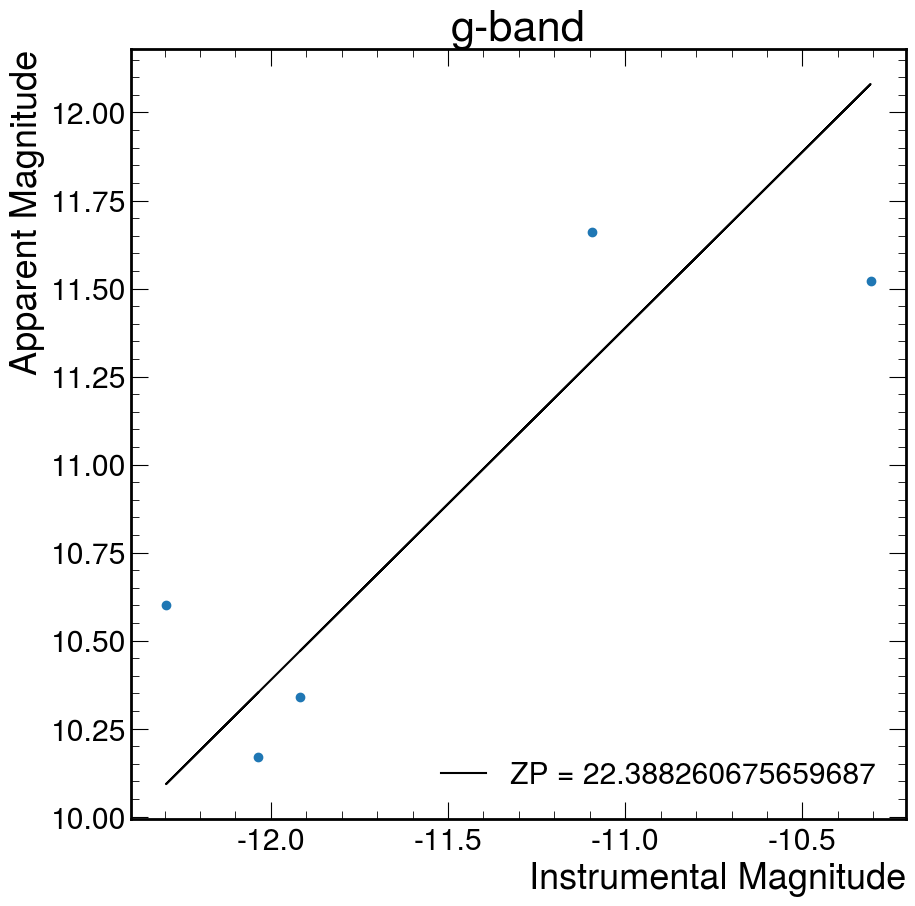

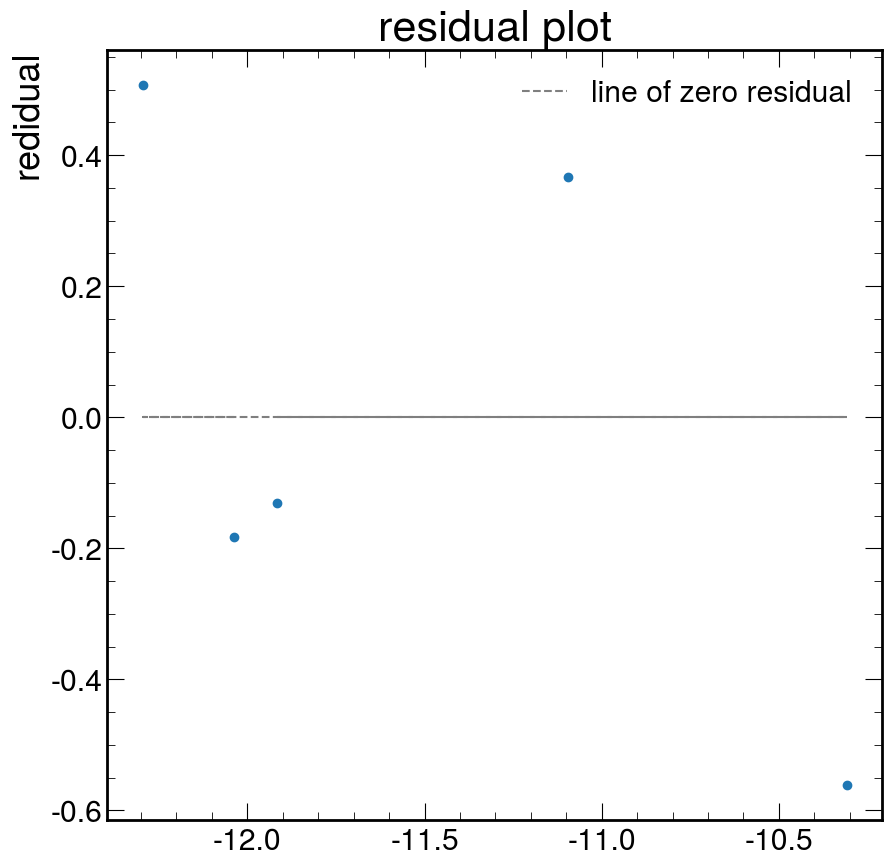

In [58]:
x = ref_g_uncali
y = np.array([10.17, 10.6, 11.52, 11.66, 10.34])

print(np.mean(x-y))

xbar = np.mean(x)
ybar = np.mean(y)
numerator=np.sum(x*y-x*ybar)
denominator=np.sum(x*x-x*xbar)
m = 1
#numerator/denominator
print ("slope: ", m)
b_g = ybar-m*xbar
print ("y intercept: ", b_g)
line = m*x +b_g


fit_line = plt.plot(x, line, color='black', label=f"ZP = {b_g}")
plt.legend(loc='lower right')
plt.scatter(x,y)
plt.xlabel("Instrumental Magnitude")
plt.ylabel("Apparent Magnitude")
plt.title('g-band')
plt.show()

residual = y - line
resid_line = x*0

plt.scatter(x, residual)
plt.title("residual plot")
plt.ylabel("redidual")
plt.plot(x,resid_line, color='black', ls='--',alpha =0.5, label="line of zero residual")
plt.legend()
plt.show()

In [59]:
print(residual, residual.mean())

    aperture_sum    
--------------------
-0.18193628090739544
  0.5076232675611898
 -0.5606215612918497
  0.3662556102755623
 -0.1313210356375052 3.552713678800501e-16


-23.301429679162887
slope:  1
y intercept:  23.301429679162887


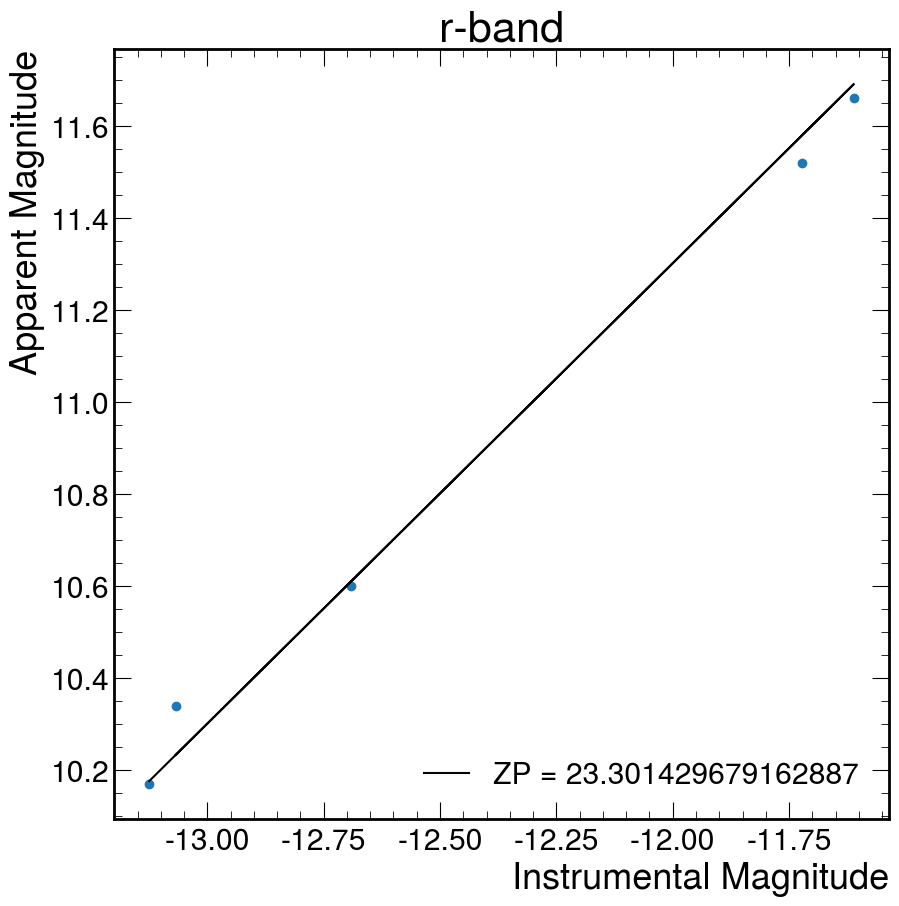

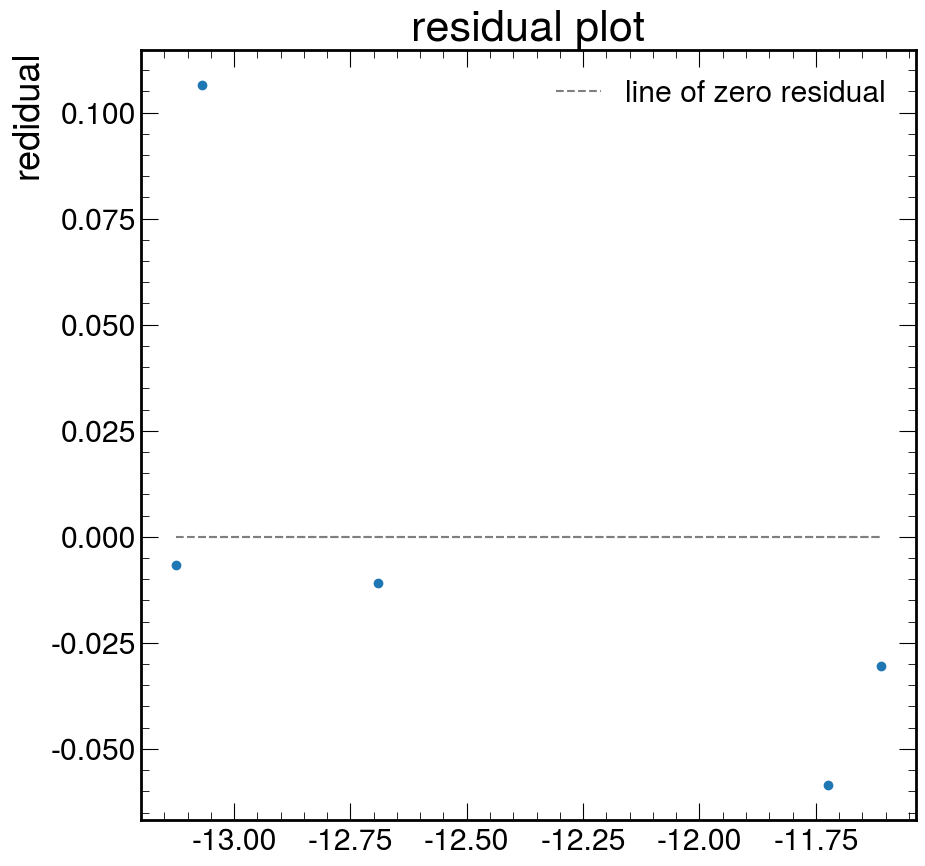

In [60]:
x = ref_r_uncali
y = np.array([10.17, 10.6, 11.52, 11.66, 10.34])

print(np.mean(x-y))

xbar = np.mean(x)
ybar = np.mean(y)
numerator=np.sum(x*y-x*ybar)
denominator=np.sum(x*x-x*xbar)
m = 1
#numerator/denominator
print ("slope: ", m)
b_r = ybar-m*xbar
print ("y intercept: ", b_r)
line = m*x +b_r


fit_line = plt.plot(x, line, color='black', label=f"ZP = {b_r}")
plt.legend(loc='lower right')
plt.scatter(x,y)
plt.xlabel("Instrumental Magnitude")
plt.ylabel("Apparent Magnitude")
plt.title('r-band')
plt.show()

residual = y - line
resid_line = x*0
plt.scatter(x, residual)
plt.title("residual plot")
plt.ylabel("redidual")
plt.plot(x,resid_line, color='black', ls='--',alpha =0.5, label="line of zero residual")
plt.legend()
plt.show()

In [61]:
print(residual, residual.mean())

     aperture_sum     
----------------------
-0.0067144559753824495
 -0.010885351832847334
 -0.058435443296701806
 -0.030543006067844658
   0.10657825717277092 -1.0658141036401502e-15


### Add zero point magnitude

In [71]:
color_cali = color + (b_g - b_r)* np.ones(len(color))
Gmag_cali = Gmag + b_g * np.ones(len(Gmag))
Rmag_cali = Rmag + b_r * np.ones(len(Gmag))

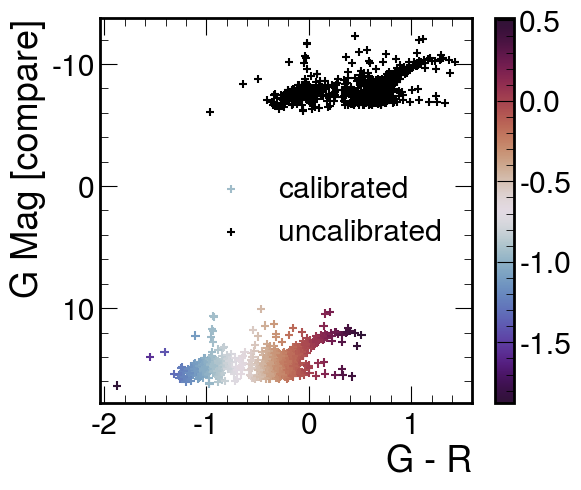

In [72]:
Gmag_cali_clipped= []
color_cali_clipped = []
color_cali = np.array(color_cali)
for i, c in enumerate(color_cali):
    if c > color_cali.mean() - 3*color_cali.std() and c < color_cali.mean() + 3*color_cali.std():
        color_cali_clipped.append(c)
        Gmag_cali_clipped.append(Gmag_cali[i])
    else:
        None
#print(len(color_cali_clipped), len(color_clipped), color.shape, len(color_cali))

plt.figure(figsize=(6,5))
plt.style.use(hep.style.ROOT)
plt.scatter(np.array(color_cali_clipped), Gmag_cali_clipped, marker='+', c = color_cali_clipped, cmap = 'twilight_shifted',label='calibrated')
plt.colorbar()
plt.scatter(np.array(color_clipped), Gmag_clipped, marker='+', c = 'k',label='uncalibrated')
plt.xlabel('G - R')
plt.ylabel('G Mag [compare]')
plt.legend()
#plt.xlim(-2, 3)
plt.gca().invert_yaxis()

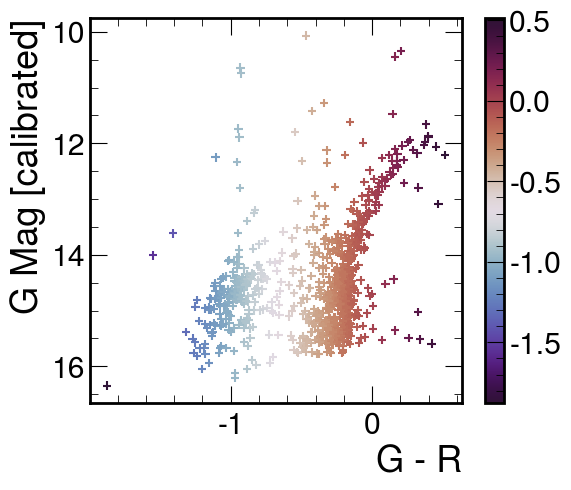

In [73]:
plt.figure(figsize=(6,5))
plt.style.use(hep.style.ROOT)
plt.scatter(np.array(color_cali_clipped), Gmag_cali_clipped, marker='+', c = color_cali_clipped, cmap = 'twilight_shifted',label='calibrated')
plt.colorbar()
plt.xlabel('G - R')
plt.ylabel('G Mag [calibrated]')
#plt.xlim(-2, 3)
plt.gca().invert_yaxis()